In [19]:
import torch 
import matplotlib.pyplot as plt 
#%matplotlib inline
import numpy as np
from bindsnet.network import Network
from bindsnet.network.nodes import Input, LIFNodes, AdaptiveLIFNodes
from bindsnet.network.topology import Connection
from bindsnet.network.monitors import Monitor
from bindsnet.analysis.plotting import plot_spikes, plot_voltages, plot_weights
from bindsnet.learning import PostPre
from bindsnet.analysis.visualization import summary, plot_spike_trains_for_example, plot_voltage
from bindsnet import encoding
from tqdm import tqdm


In [20]:
#define the helper's function

def loss_output(y,a_out):
    '''
    calculate the objective/Loss function
    at the last layer
    output : Loss tensor
    :param y (tensor): target label : 
    :param a_out (tensor): spike activity at the output layer
    '''
    o_de = 1 if (torch.max(torch.sum(a_out,dim=0))==0) else torch.max(torch.sum(a_out,dim=0))
    #o = torch.sum(a_out,dim=0) / torch.max(torch.sum(a_out,dim=0))    
    o = torch.sum(a_out,dim=0) / o_de   
    Loss = 0.5 * torch.pow(torch.norm(o - y),2)
    return Loss

def error_backprop_out(net,y,a_out):
    '''
    calculate the error at the output layer
    output : error tensor for each neuron in the layer
    input : net, network object
    input : y , target label
    input : a_out, spike activity at the output layer
    '''
    vth = net.layers["C"].thresh
    o_de = 1 if (torch.max(torch.sum(a_out,dim=0))==0) else torch.max(torch.sum(a_out,dim=0))
    #o_vec = torch.sum(a_out,dim=0) / torch.max(torch.sum(a_out,dim=0))
    o_vec = torch.sum(a_out,dim=0) / o_de
    #denom = 1 if (np.sqrt(torch.count_nonzero(o_vec - y)) == 0) else np.sqrt(torch.count_nonzero(o_vec - y))
    denom = np.sqrt(torch.count_nonzero(o_vec - y))
    #delta_Loss = (o_vec - y) / (denom +1)
    delta_Loss = (o_vec - y) / vth
    return delta_Loss


def error_backprop(net,a_hidden,a_out,deltai_nxt):
    '''
    calculate the backprop error for each layer except output layer
    output : the error backprop tensor with dimension 1 x Number of neurons in that layer
    :param : net, network object
    :input : input data
    :a_hidden : spike activity output at the hidden layer
    :a_out : spike activit output at the output/last layer
    :deltai_nxt : backprop error from the next layer
    '''
    #w = list(net.parameters())
    wij = net.connections['B','C'].w          #get the weight of the hidden layer
    Vth = net.layers["B"].thresh
    M = net.layers["B"].n#total synapses in the next layer
    m = torch.sum(a_out,dim=0).nonzero()#vector of active synapses in the next layer  
    n = torch.sum(a_hidden,dim=0).nonzero() #vector of active neuron in the next layer
    #n = 1 if (torch.sum(a_hidden,dim=0).nonzero()==0) else torch.sum(a_hidden,dim=0).nonzero()
    g_i   = 1 / Vth
    g_bar = np.sqrt((1/(1+len(n))) * torch.sum(torch.pow(g_i[n],2)))
    deltai = (g_i / g_bar) * np.sqrt(M/(1+len(m))) * (wij @ deltai_nxt)
    return deltai
    #return g_bar

def aux_spike_activity(spike, ref_spike,tmp = 100,T=350,isPlot = True):
    '''
    calculate the continous real value spike activity based on the equation 4
    from paper Lee.et.al (2016)
    output : tensor/vector of accumulated effects of spike at the final observation time T
    input  : spike, spike activity representd in 1 or 0
    input  : ref_spike, the reference function to save computational time
    input  : tmp, time constant of decaying spike signal
    input  : T, observation time
    '''
    dt = torch.linspace(0,T-1,T) #the time axis
    xk   = torch.zeros(spike.shape) #variable to store continous real value of accummulated. spike signal    
    
    """ if (ref_spike == None):
        y = torch.exp(-dt/tmp)
    else:
        y = ref_spike    """
    y = ref_spike
    sidx = (spike).nonzero().numpy() #get the index of the spike

    # plot the binary spike activity
    if isPlot:        
        spikes = {"A":spike}
        plt.figure()
        plot_spikes(spikes)

    # calculate the accumulated spike activity    
    for id,val in enumerate(sidx):
        if val[0]==0:
            xk[:,val[1]] = np.add(xk[:,val[1]],y)
        else:
            xk[:,val[1]] = np.add(xk[:,val[1]],[*np.zeros(val[0]),*y[0:-val[0]]])

    # plot the spike signal
    if isPlot:      
        plt.figure(figsize=[10,5])
        plt.plot(dt,xk)
        plt.title("Accumulated spike activity")
        plt.xlabel("Time Steps")
        #put some legend :)
        list_legend = []
        for i in range(spike.size(1)):
            list_legend.append('neuron %s'%i)
        plt.legend((list_legend),loc='best')
        plt.show()
    # return the last value of accum spike activity    
    return xk[-1,:]


    
def delta_weight(etaw,N,m,deltai,xj):
    '''
    calculate the delta weights in each layer
    output : the vector of weight of each layer
    input : etaw, learning rate
    input : N, total neuron in layer
    input : m, total of active synapses in layer
    input : deltai, vector of error backprop
    input : xj,vector of effective input spike activity
    '''
    di = torch.reshape(deltai,[1,len(deltai)])    
    #x_j = torch.sum(xj,dim=0)
    x_j = xj.reshape([len(xj),1])
    return -etaw * np.sqrt(N/(1+m)) * di * x_j

def delta_thrs(etath,N,m,M,deltai,ai):
    '''
    calculate the delta threshold in each neuron in layer
    output : the vector of voltage threshold of each layer
    input : etath, learning rate
    input : N, total neuron in layer
    input : m, total of active synapses in layer
    input : M, total synapses in the layer
    input : deltai, vector of error backprop
    input : ai,vector of effective output spike activity
    '''
    #di  = torch.reshape(deltai,[1,len(deltai)])
    #a_i = torch.sum(ai,dim=0)
    #a_i = a_i.reshape([len(a_i),1])
    return -etath * np.sqrt(N/((1+m)*M)) * deltai * ai



def update_params(net,etaw,etath,di_out,di_hid,a_out,a_hid,x_out,x_hid,ref_spike,tmp,T):
    '''torch.max(torch.sum(a_out,dim=0))
    calculate the delta weights and thresholds and update its value
    :input : net
    :
    '''
    N_out   = net.layers["C"].n#total neuron in the output layer
    N_hid   = net.layers["B"].n#total neuron in the hidden layer
    M_out   = N_hid #total synapses in the output layer
    M_hid   = net.layers["A"].n#total synapses in the hidden layer

    m_out   = len(torch.sum(a_out,dim=0).nonzero())#total active synapses in the output layer
    m_hid   = len(torch.sum(a_hidden,dim=0).nonzero())#total active synapses in the hidden layer

    #w   = list(net.parameters())
    w   = {'out':net.connections['B','C'].w,'hid':net.connections['A','B'].w}
    vth = [net.layers["B"].thresh,net.layers["C"].thresh]
    #calculate the auxillary spike activity
    
    x_hid_aux = x_hid#aux_spike_activity(x_hid, ref_spike,tmp = tmp,T=T,isPlot = False)
    a_hid_aux = aux_spike_activity(a_hid, ref_spike,tmp = tmp,T=T,isPlot = False) 
    x_out_aux = a_hid_aux
    a_out_aux = aux_spike_activity(a_out, ref_spike,tmp = tmp,T=T,isPlot = False)
    #1. weight in the last layer
    dwout = delta_weight(etaw,N_out,m_out,di_out,x_out_aux)    
    w['out'].add_(dwout) #update the parameters
    #2. weight in the middle layer
    dwhid = delta_weight(etaw,N_hid,m_hid,di_hid,x_hid_aux)
    w['hid'].add_(dwhid) #update the parameters
    #print("last layer delta w ",dwout)
    
    #3. threshold in the last layer
    d_thout = delta_thrs(etath,N_out,m_out,M_out,di_out,a_out_aux)
    vth[1].add_(d_thout)
    #4. threshold in the middle layer
    d_thid = delta_thrs(etath,N_hid,m_hid,M_hid,di_hid,a_hid_aux)
    vth[0].add_(d_thid)


def build_network(network,nodes,alpha,time,T_ref,tmp,v_rest,v_thresh,prt_sum=True):
    '''
    Procedure to build the SNNs with its specified number of nodes and layer and other parameters
    

    '''

    #initialize the voltage threshold
    vth = [alpha[0]*np.sqrt(3.0/nodes[0]), alpha[1]*np.sqrt(3.0/nodes[1])]
    thres1 = (v_rest+ vth[0]) + torch.zeros(1,nodes[1])
    thres2 = (v_rest+vth[1]) + torch.zeros(1,nodes[2])

    #define the type of neuron used in each layer
    source_layer = Input(n=nodes[0],traces=True)
    hidden_layer = LIFNodes(n=nodes[1],trace=True,refrac=T_ref,thresh=thres1.squeeze(),tc_decay=t_mp,lbound=v_rest - vth[0])
    target_layer = LIFNodes(n=nodes[2],traces=True,refrac=T_ref,thresh=thres2.squeeze(),tc_decay=t_mp,lbound=v_rest - vth[1])
    #adding layer to the network
    network.add_layer(
        layer = source_layer, name="A"
    )
    network.add_layer(
        layer = hidden_layer, name="B"
    )
    network.add_layer(
        layer = target_layer, name="C"
    )

    #create a connection between input and hidden layers
    forward_connection1 = Connection(
        source = source_layer,
        target= hidden_layer,
        #weight initialization according to Lee et.al    
        w = (np.sqrt(3.0/source_layer.n)) - 2*np.sqrt(3.0/source_layer.n)*torch.rand(source_layer.n, hidden_layer.n),
    )
    network.add_connection(
        connection=forward_connection1, source="A", target="B"
    )
    #create a connection between hidden layer and output layer
    forward_connection2 = Connection(
        source = hidden_layer,
        target = target_layer,
        #weight initialization according to Lee et.al    
        w = (np.sqrt(3.0/hidden_layer.n)) - 2*np.sqrt(3.0/hidden_layer.n)*torch.rand(hidden_layer.n, target_layer.n),    
    )
    network.add_connection(
        connection=forward_connection2, source="B", target="C"
    )
    #create a recurrent connection in output layer
    # Winner take all circuit
    recurrent_connection = Connection(
        source = target_layer,
        target= target_layer,
        w = 0.001 * (torch.eye(target_layer.n)-1),
        #w = 0.6 * (torch.eye(target_layer.n)-1),
    )

    network.add_connection(
        connection=recurrent_connection, source="C", target="C"
    )

    #create and add input and output layer monitor
    source_monitor = Monitor(
        obj = source_layer,
        state_vars = ("s",), #record spikes and voltages
        time = time , 
    )
    hidden_monitor = Monitor(
        obj = hidden_layer,
        state_vars=("s","v"),
        time = time ,
    )
    target_monitor = Monitor(
        obj = target_layer,
        state_vars= ("s", "v"),
        time = time ,
    )
    #at the monitor to the network
    network.add_monitor(monitor=source_monitor, name="A")
    network.add_monitor(monitor=hidden_monitor, name="B")
    network.add_monitor(monitor=target_monitor, name="C")

    if prt_sum:
        #print th network summary
        print(summary(network))

        #investigate the weight in forward and recurrent connection
        w1 = forward_connection1.w
        w2 = forward_connection2.w
        k1 = recurrent_connection.w 
        vth1 = network.layers["B"].thresh
        vth2 = network.layers["C"].thresh
        print("max and min of 1st forward connection weights"+str(torch.max(w1))+" "+str(torch.min(w1)))
        print("max and min of 2nd forward connection weights"+str(torch.max(w2))+" "+str(torch.min(w2)))
        print("max and min of recurrent weights "+str(torch.max(k1))+" "+str(torch.min(k1)))

        #check wheter or not the weigths satisfy the equation 11
        print(torch.sum(torch.pow((forward_connection2.w),2),dim=0))
        print(torch.sum(torch.pow((forward_connection1.w),2),dim=0))
        #plot the weights
        plt.figure()
        plot_weights(forward_connection1.w,wmin=-1,figsize=[6,6])
        plt.figure()
        plot_weights(forward_connection2.w,wmin=-1,figsize=[6,6])
        plt.show()

def generate_input(spike_rate,nodes,time,batch,prt_input=True):
    '''
    generate dummy random spike dataset to feed to the network
    output : input_data, random input data with dimension input_neuron * time_step
    output : y, target label in one hot encoding
    output : vary , target label in 
    input : spike_rate , max spike rate in Hz
    input : time, time for each training sample
    input : batch, the number of training sample in a batch
    '''
    input_data = torch.zeros(time * batch , nodes[0])
    for j in range(batch):
        input_rates = spike_rate * torch.rand(nodes[0])
        input_data[j*time:(j*time)+time,:]= encoding.poisson(datum=input_rates, time=time)  

    inputs = {"A":input_data}

    vary = torch.randint(low=0,high=nodes[2],size=[batch])
    if torch.max(vary) < 3:
        vary = vary + 1
    if batch == 1:
        y = torch.tensor([0, 1, 0, 0],dtype=torch.uint8) #target label
    else:
        y = torch.nn.functional.one_hot(vary)

    if prt_input:
        print("Target labels ",y)
        #plot the input train spike
        plt.ioff()
        plt.figure()
        plot_spikes(inputs)
        plt.show()
    return input_data, y, vary 


         NETWORK SUMMARY
         batch size:1
    ··········································
    Layer: 'A' (trainable)
   20 neurons [20]
       ·connected to 'B' by 800 synapses
    ··········································
    Layer: 'B' (trainable)
   40 neurons [40]
       ·connected to 'C' by 160 synapses
    ··········································
    Layer: 'C' (trainable)
   4 neurons [4]
       ·connected to 'C' by 16 synapses
Total neurons: 64 (64 trainable)
Total synapses weights: 976 (976 trainable)
max and min of 1st forward connection weightstensor(0.3866) tensor(-0.3869)
max and min of 2nd forward connection weightstensor(0.2731) tensor(-0.2717)
max and min of recurrent weights tensor(0.) tensor(-0.0010)
tensor([1.1622, 1.1601, 0.9371, 1.1127])
tensor([1.1898, 0.8879, 1.1985, 0.9717, 1.0063, 1.2886, 1.0052, 1.1533, 0.9569,
        0.8650, 0.8306, 0.8520, 1.1386, 0.4939, 0.6181, 1.0181, 0.9207, 1.0196,
        0.9564, 1.0062, 0.8904, 1.0801, 1.0527, 0.9260, 0.4557, 

<Figure size 432x288 with 0 Axes>

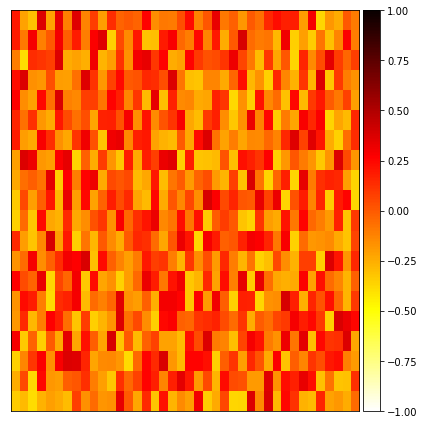

<Figure size 432x288 with 0 Axes>

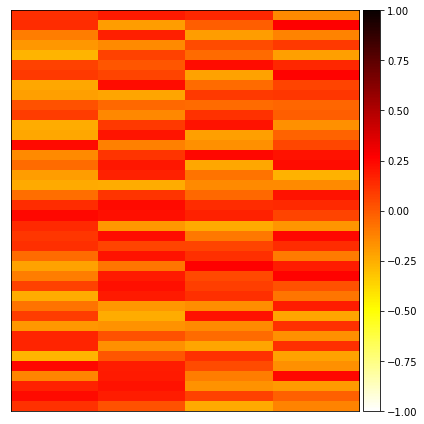

In [21]:

#the networks parameters according Lee et.al(2016)
time = 350 #time for each training sample
alpha = [8 ,3] #to control how strong the threshold voltage initialization
beta  = 10
lamda = 0.002
rho   = 0.0001
T_ref = 1               #refractory period
t_mp  = 100            #decay time
v_rest = -65          #default neuron rest voltage
v_thresh   = -52          #default neuron threshold voltage

#create the network
network = Network()
#create and add input, output layers

#voltage threshold as a vector 
# the value corresponds to every vth in each node
nodes = [20, 40, 4] #number of nodes in each layer

#initialize the network
build_network(network=network,nodes=nodes,alpha=alpha,time=time,T_ref=T_ref,tmp=t_mp,v_rest=v_rest,v_thresh=v_thresh,prt_sum=True)



Target labels  tensor([[1, 0, 0, 0],
        [1, 0, 0, 0],
        [0, 1, 0, 0],
        [0, 0, 1, 0],
        [0, 0, 0, 1],
        [0, 0, 0, 1],
        [0, 0, 1, 0],
        [1, 0, 0, 0]])


<Figure size 432x288 with 0 Axes>

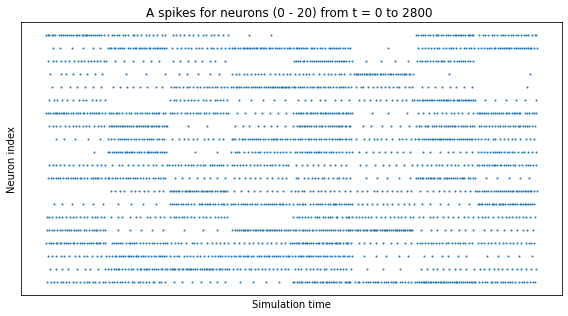

In [22]:
#create input spike data, where each spike is distributed according poisson distribution

spike_rate = 100 #maximum spike rate in hz
batch = 8 #batch size
dt = torch.linspace(0,time-1,time) #the time axis
ref_spike = torch.exp(-dt/t_mp) ##spike referrence 

input_data, y, vary = generate_input(spike_rate,nodes,time,batch,prt_input=True)

#generate the input spike auxilliary activity
input_spike_aux = torch.zeros(nodes[0],batch)
#iterate over each data in batch
for i in range(batch):
    input_spike_aux[:,i] = aux_spike_activity(input_data[i*time:(i*time)+time,:], ref_spike,tmp = 100,T=350,isPlot = False)


In [23]:
#begin the training procedure

#loop for 150 epochs
eta_w  = 0.04        #learning rate for synaptic weight
eta_th = 1 * eta_w  #learning rate for voltage threshold
epochs = 100
L = torch.zeros(epochs) #store in the vector
l = torch.zeros(batch)
plot_train = False
y_pred = torch.zeros(batch,nodes[2])


for i in range(epochs): #loop for each epoch         
    for j in tqdm(range(batch)): #loop for each training sample in a batch
        #1. run forward propagation 
        inputs = {"A":input_data[j*time:(j*time)+time,:]}
        network.run(inputs=inputs,time=time)
        #1.1 obtain the spike activity in each nodes of every layer
        #x -> 
        spikes = {       
        "A" : network.monitors["A"].get("s"),
        "B" : network.monitors["B"].get("s"),
        "C" : network.monitors["C"].get("s")
        }
        
        a_hidden = spikes["B"].squeeze().float() #get the spike activity at the hidden layer
        a_out    = spikes["C"].squeeze().float() #get the spike activity at the output layer           

        #save the spike activity value
        y_pred[j,:] = torch.sum(a_out,dim=0)
        
        #print(torch.sum(a_out,dim=0)) #print the spike's output activity
        #print(torch.sum(a_hidden,dim=0)) #print the spike's hidden activity

        #x_hidden = inputs["A"].squeeze()#input_data
        x_hidden = input_spike_aux[:,j]
        x_out    = a_hidden

        #2. calculate and keep track the loss
        if (batch==1): #if the only one training sample used
            l[j] = loss_output(y,a_out)       #y[j,:] 

            delta_i_out    =  error_backprop_out(network,y,a_out)#y[j,:]
        else: #multiple training sample in  a batch
            l[j] = loss_output(y[j,:],a_out)       

            delta_i_out    =  error_backprop_out(network,y[j,:],a_out)
        
        #3.propagate the error backprop        
        delta_i_hid    =  error_backprop(network,a_hidden,a_out,delta_i_out)    
        
        #4.update the paramaters (weight & threshold)
        update_params(network,eta_w,eta_th,delta_i_out,delta_i_hid,a_out,a_hidden,x_out,x_hidden,ref_spike,t_mp,time)        

        #5.reset the membrane potential in the network
        network.layers["C"].reset_state_variables()
        network.layers["B"].reset_state_variables()      

    L[i] = torch.sum(l) / batch
    #print("vector l",l)
    print(" epochs , loss : ",i,L[i])
    if L[i] < 0.025: #if the loss is less than specified value
            break #stop the loop



100%|██████████| 8/8 [00:02<00:00,  2.99it/s] epochs , loss :  13 tensor(0.)



In [24]:
#run the final prediction
y_pred_run = torch.zeros(batch,nodes[2])
for j in range(batch):
    inputs = {"A":input_data[j*time:(j*time)+time,:]}
    network.run(inputs=inputs,time=time)
    a_out    = network.monitors["C"].get("s").squeeze().float()
    y_pred_run[j] = torch.sum(a_out,dim=0)
    #reset state variables 
    network.layers["C"].reset_state_variables()
    network.layers["B"].reset_state_variables()

print("Output spike final prediction (one hot)")
print(y_pred_run)
print("target label (one hot)")
print(y)

print("output vector %s"%(torch.argmax(y_pred_run,dim=1)))
print("target vector %s"%vary)
#calculate accuracy
acc = sum(torch.argmax(y_pred_run,dim=1)==vary)*100/batch
print("Accuracy %s "%acc.item())



Output spike final prediction (one hot)
tensor([[1., 0., 0., 0.],
        [1., 0., 0., 0.],
        [0., 1., 0., 0.],
        [0., 0., 1., 0.],
        [0., 0., 0., 3.],
        [0., 0., 0., 1.],
        [0., 0., 1., 0.],
        [1., 0., 0., 0.]])
target label (one hot)
tensor([[1, 0, 0, 0],
        [1, 0, 0, 0],
        [0, 1, 0, 0],
        [0, 0, 1, 0],
        [0, 0, 0, 1],
        [0, 0, 0, 1],
        [0, 0, 1, 0],
        [1, 0, 0, 0]])
output vector tensor([0, 0, 1, 2, 3, 3, 2, 0])
target vector tensor([0, 0, 1, 2, 3, 3, 2, 0])
Accuracy 100.0 


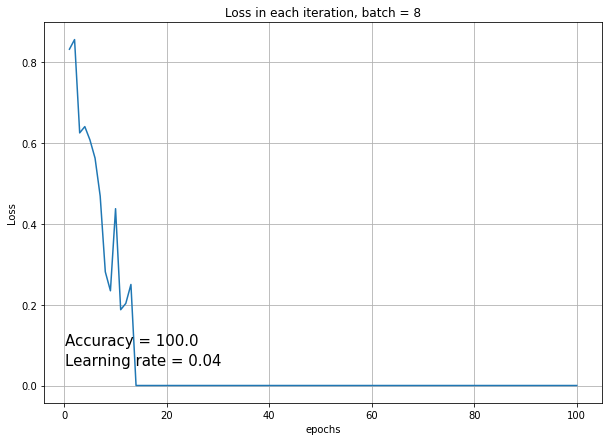

In [25]:
#plot the loss in each iteration
x_ax = np.linspace(1,len(L),len(L))
plt.figure(figsize=[10,7])
plt.plot(x_ax,L)
plt.title("Loss in each iteration, batch = %s"%batch)
plt.ylabel("Loss",)
plt.xlabel("epochs")
plt.text(0.05,0.05,"Learning rate = %s"%eta_w, fontsize=15)
plt.text(0.05,0.1,"Accuracy = %s"%acc.item(), fontsize=15)
plt.grid(True)

plt.show()

<Figure size 432x288 with 0 Axes>

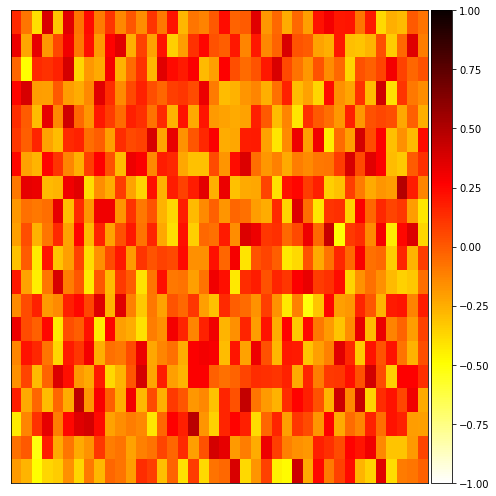

<Figure size 432x288 with 0 Axes>

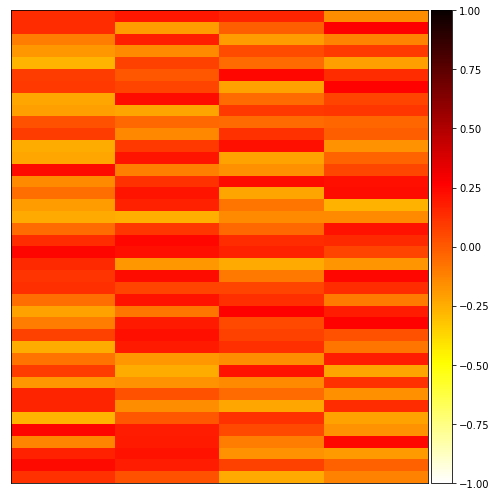

In [26]:
#plot the final weights
w1 = network.connections['A','B'].w
w2 = network.connections['B','C'].w
plt.figure()
plot_weights(w1,wmin=-1,figsize=[7,7])
plt.figure()
plot_weights(w2,wmin=-1,figsize=[7,7])

In [27]:
#print the voltage threshold
print("voltage threshold at the output layer ",network.layers["C"].thresh)
print("voltage threshold at the hidden layer ",network.layers["B"].thresh)

voltage threshold at the output layer  tensor([-64.1770, -64.1775, -64.1772, -64.1776])
voltage threshold at the hidden layer  tensor([-61.9094, -61.9016, -61.9016, -61.8999, -61.9017, -61.9068, -61.9013,
        -61.9021, -61.8995, -61.9016, -61.9016, -61.9080, -61.9043, -61.9016,
        -61.9002, -61.9079, -61.9022, -61.9018, -61.8999, -61.9030, -61.9051,
        -61.9016, -61.9042, -61.9011, -61.9019, -61.9016, -61.9004, -61.9019,
        -61.9016, -61.9016, -61.9020, -61.9033, -61.9015, -61.9026, -61.9016,
        -61.9060, -61.9016, -61.9019, -61.9022, -61.9016])


<Figure size 432x288 with 0 Axes>

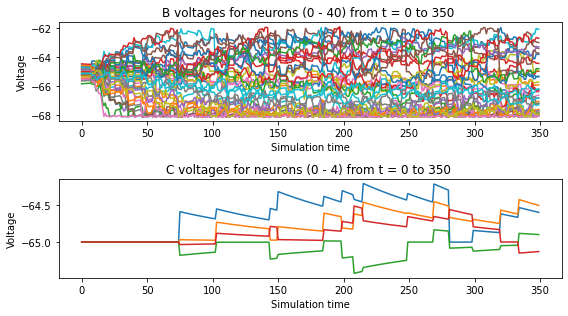

membrane voltage value before reset
tensor([[-65., -65., -65., -65., -65., -65., -65., -65., -65., -65., -65., -65.,
         -65., -65., -65., -65., -65., -65., -65., -65., -65., -65., -65., -65.,
         -65., -65., -65., -65., -65., -65., -65., -65., -65., -65., -65., -65.,
         -65., -65., -65., -65.]])
tensor([[-65., -65., -65., -65.]])


In [28]:
#plot the voltage 
voltages = {
    "B" : network.monitors["B"].get("v"),
    "C" : network.monitors["C"].get("v")
}
plt.figure()
plot_voltages(voltages, plot_type="line")
plt.show()
print("membrane voltage value before reset")
print(network.layers["B"].v)
print(network.layers["C"].v)

In [30]:
#print(forward_connection1.w)
print("Expected value of sum of weights in each neuron") #according to equation 11 (2016)Lee.et.al
print("Hidden layer")
print(torch.sum(torch.pow((w1),2),dim=0))
print("Output layer")
print(torch.sum(torch.pow((w2),2),dim=0))

Expected value of sum of weights in each neuron
Hidden layer
tensor([0.9265, 0.8556, 1.7420, 1.0850, 1.3764, 1.1740, 1.1788, 1.2289, 1.1598,
        0.8751, 0.7734, 0.6016, 1.1534, 0.7007, 0.8143, 0.9956, 0.8215, 1.0529,
        1.0288, 1.0396, 0.9204, 0.9719, 1.1093, 0.9197, 0.5287, 1.1254, 1.3231,
        1.3065, 0.9938, 0.8936, 1.0743, 1.1056, 1.1058, 1.1072, 1.0898, 0.9844,
        1.6017, 1.0246, 0.9862, 0.6787])
Output layer
tensor([1.1763, 1.1679, 0.9556, 1.1239])
